In [1]:
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt

import artm

# Адрес, по которому находятся данные
BATCH_ADRESS = 'batches_news_ria'

# Вывод версии BigARTM
print(artm.version())

0.10.0


In [2]:
# Установка адреса, по которому находятся данные
batch_vectorizer = artm.BatchVectorizer(
    data_path=BATCH_ADRESS, data_format='batches'
)

In [3]:
# Пересоздание словаря для модели и сохранение его в файл

# Устанавливается название словаря для модели
dictionary_address = BATCH_ADRESS + '/dictionary.dict'

# Инициализация словоря для модели
dictionary = artm.Dictionary()

# Удаление словаря, оставшегося после предыдущих запусков
if os.path.isfile(dictionary_address):
    os.remove(dictionary_address)
    
# Сохранение словаря в файл
dictionary.gather(data_path=batch_vectorizer.data_path)
dictionary.save(dictionary_path=dictionary_address)

# Загрузка словаря из файла
dictionary.load(dictionary_path=dictionary_address)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре"
)


# Фильтрация

# Убираются редкие слова по всей коллекции
# Слово встречается во всей коллекции больше чем n раз
dictionary.filter(min_tf=10)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре после фильтрации по min_tf", 
)

# Убираются частые слова по всей коллекции
# Слово встречается во всей коллекции меньше чем n раз
dictionary.filter(max_tf=2000)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре после фильтрации по max_tf", 
)

# Убираются слова, которые попадаются меньше чем в n процентов документов
dictionary.filter(min_df_rate=0.0001)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре после фильтрации по min_df_rate", 
)

# Убираются слова, которые попадаются больше чем в n процентов документов
dictionary.filter(max_df_rate=0.6)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре после фильтрации по max_df_rate", 
)

  88657 - количество слов в словаре
  21068 - количество слов в словаре после фильтрации по min_tf
  20685 - количество слов в словаре после фильтрации по max_tf
  20470 - количество слов в словаре после фильтрации по min_df_rate
  20470 - количество слов в словаре после фильтрации по max_df_rate


In [4]:
def new_default_model(topic_count, dictionary):
    
    # Создание модели
    model_artm = artm.ARTM(
        # Названия тем
        topic_names=['topic_{0:0>3}'.format(i) for i in range(topic_count)], 
        # Разрешается хранить матрицу theta в памяти
        cache_theta=True,
        # Фиксация seed для воспроизвдимости результатов
        seed=-1,
        # Настройка - сколько раз обрабатывать каждый документ
        num_document_passes=1,
        # Модальности
        #class_ids={'text': 1.0},
    )

    # Инициализация модели
    model_artm.initialize(dictionary=dictionary)

    # Установка отслеживаемых параметров
    # Перплексия (чем она меньше тем лучше)
    model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore'))
    # Разреженность матрицы Phi (доля почти нулевых значений)
    model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
    # Разреженность матрицы Theta (доля почти нулевых значений)
    model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    # Анализ самых используемых слов по темам
    model_artm.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10))
    # Анализ ядра тем на контраст и чистоту
    model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore'))
    #model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3))
    
    return model_artm

In [5]:
def model_print_results(model_artm):
    
    # Графики
    
    fig = plt.figure(figsize=(15, 20))

    ax = plt.subplot2grid((4,3), (0,0), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker["PerplexityScore"].value, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('PerplexityScore')
    ax.grid(True)

    ax = plt.subplot2grid((4,3), (0,1), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker["SparsityPhiScore"].value, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('SparsityPhiScore')
    ax.grid(True)
    ax.set_ylim([0,1])

    ax = plt.subplot2grid((4,3), (0,2), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker["SparsityThetaScore"].value, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('SparsityThetaScore')
    ax.grid(True)
    ax.set_ylim([0,1])


    ax = plt.subplot2grid((4,3), (1,0), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker["TopicKernelScore"].average_contrast, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('TopicKernelScore_average_contrast')
    ax.grid(True)
    ax.set_ylim([0,1])

    ax = plt.subplot2grid((4,3), (1,1), colspan = 2, rowspan = 1,  fig=fig)
    my_contrast_dictionary = model_artm.score_tracker['TopicKernelScore'].last_contrast
    ax.bar(my_contrast_dictionary.keys(), my_contrast_dictionary.values(), 0.5, color='tab:blue')
    ax.set_xlabel('//')
    ax.set_ylabel('//')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylim([0,1])


    ax = plt.subplot2grid((4,3), (2,0), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker['TopicKernelScore'].average_purity, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('TopicKernelScore_average_purity')
    ax.grid(True)
    ax.set_ylim([0,1])

    ax = plt.subplot2grid((4,3), (2,1), colspan = 2, rowspan = 1,  fig=fig)
    my_purity_dictionary = model_artm.score_tracker['TopicKernelScore'].last_purity
    ax.bar(my_purity_dictionary.keys(), my_purity_dictionary.values(), 0.5, color='tab:blue')
    ax.set_xlabel('//')
    ax.set_ylabel('//')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylim([0,1])


    ax = plt.subplot2grid((4,3), (3,0), colspan = 1, rowspan = 1,  fig=fig)
    my_average_size = model_artm.score_tracker['TopicKernelScore'].average_size
    ax.plot(my_average_size, color='tab:blue')
    ax.plot([model_artm.phi_.shape[0]/model_artm.num_topics for i in range(len(my_average_size))], color='tab:orange')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('TopicKernelScore_average_size')
    ax.grid(True)
    ax.set_ylim([0,ax.get_ylim()[1]])

    ax = plt.subplot2grid((4,3), (3,1), colspan = 2, rowspan = 1,  fig=fig)
    my_size_dictionary = model_artm.score_tracker['TopicKernelScore'].last_size
    ax.bar(my_size_dictionary.keys(), my_size_dictionary.values(), 0.5, color='tab:blue')
    ax.plot([model_artm.phi_.shape[0]/model_artm.num_topics for i in range(model_artm.num_topics)], color='tab:orange')
    ax.set_xlabel('//')
    ax.set_ylabel('//')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=90)

    plt.show()
    
    
    # Конечные значения
    
    print("PerplexityScore:", model_artm.score_tracker["PerplexityScore"].last_value)
    print("SparsityPhiScore:", model_artm.score_tracker["SparsityPhiScore"].last_value)
    print("SparsityThetaScore:", model_artm.score_tracker["SparsityThetaScore"].last_value)
    print()
    print("TopicKernelScore_average_contrast:", model_artm.score_tracker["TopicKernelScore"].last_average_contrast)
    print("TopicKernelScore_average_purity:", model_artm.score_tracker['TopicKernelScore'].last_average_purity)
    print("TopicKernelScore_average_size:", model_artm.score_tracker['TopicKernelScore'].last_average_size)
    
    print()
    
    
    # Главные слова в темах
    
    print("TopTokensScore:")
    topic_list = list(model_artm.score_tracker['TopTokensScore'].last_tokens.keys())
    for topic_name in topic_list:
        print(topic_name + ': ', end='')
        for token_name in model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name]:
            print(token_name, end=' ')
        print()

In [6]:
params = {
    'topic_count': 100,
    'num_collection_passes': 40,
    'SparsePhi': {
        'name': 'SparsePhi',
        'tau': -5,
    },
    'SparseTheta': {
        'name': 'SparseTheta',
        'tau': -3,
    },
    'DecorrelatorPhi': {
        'name': 'DecorrelatorPhi',
        'tau': 25_000_000,
    }
}

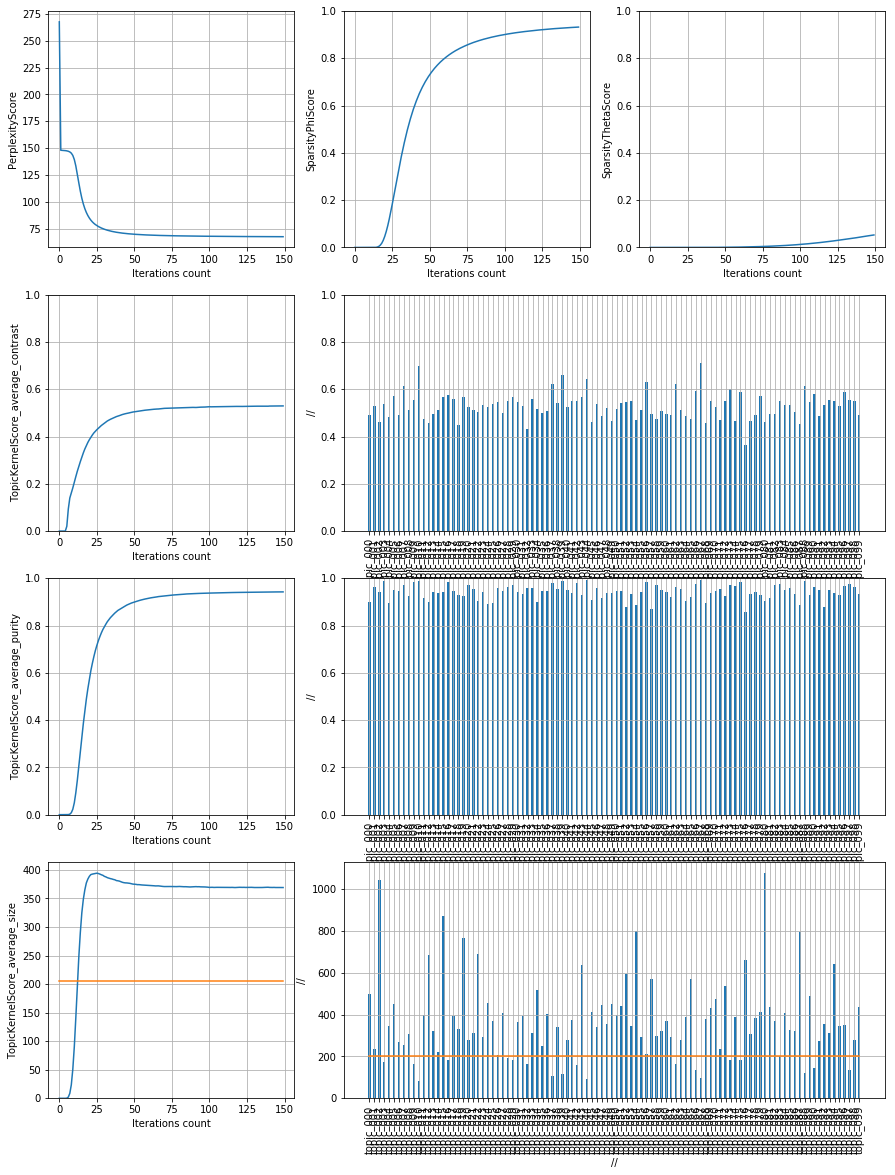

PerplexityScore: 67.61663055419922
SparsityPhiScore: 0.9324215650558472
SparsityThetaScore: 0.05282556638121605

TopicKernelScore_average_contrast: 0.529502272605896
TopicKernelScore_average_purity: 0.9426426887512207
TopicKernelScore_average_size: 369.07000732421875

TopTokensScore:
topic_000: использовать ученый исследование примерно коллега степень анализ изучать внутри зависимость 
topic_001: пост палата возглавлять полномочие отставка собрание президентский обязанность действующий парламентский 
topic_002: рука маленький правда подходить узнавать глаз совсем голова слишком совпадать 
topic_003: поддерживать участвовать франция сено открытый игорь нынешний инициатива французский объединение 
topic_004: западный восток турция восточный израиль сектор турецкий израильский ближний палестинский 
topic_005: владивосток море вертолет морской поиск корабль дальний флот приморье приморский 
topic_006: граница ассоциация партнер торговля формирование перспектива свободный делегация посол та

topic_079: сезон этап завершаться четвертый серия испания пятый гонка стартовать бразилия 
topic_080: роль режиссер снимать кино актер картина кадр актриса герой любовь 
topic_081: кандидат голос голосование избирательный избиратель кампания набирать проголосовать опрос молдавия 
topic_082: понимать разный видеть собственный интервью всегда часто опыт далеко уверенный 
topic_083: округ реализация обеспечивать обеспечение дополнительный выделять совещание финансирование увеличивать субъект 
topic_084: квартира жилье квадратный жилой помещение ремонт муниципальный земельный этаж жилищный 
topic_085: законодательство чиновник административный рассмотрение основание штраф постановление имущество судебный правовой 
topic_086: кризис греция внешний увеличение расход снижение риск расти прайм сокращение 
topic_087: современный искусство собирать организатор фотография художник коллекция открываться посетитель экспозиция 
topic_088: образ лишь приходиться теперь мало поскольку большинство мене

In [7]:
# Создание базовой пустой модели
model_artm = new_default_model(params['topic_count'], dictionary)

# Модель 0_0
# Запуск регуляризатора SparsePhi

# Обучение модели
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=150)

# Вывод метрик модели
model_print_results(model_artm)

# Сохранение модели
model_artm.save("news_model_0_0")
model_artm_0_0 = model_artm.clone()

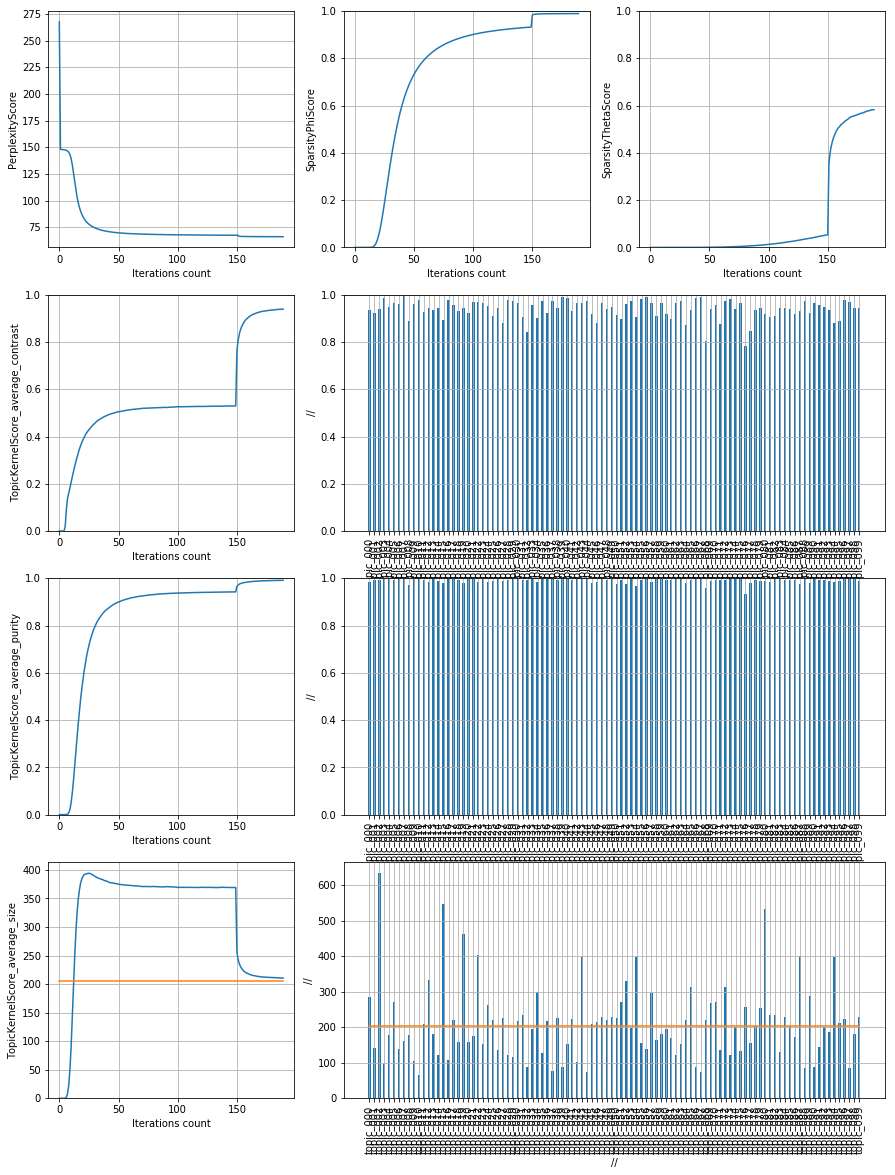

PerplexityScore: 66.26509094238281
SparsityPhiScore: 0.9894548058509827
SparsityThetaScore: 0.5831674337387085

TopicKernelScore_average_contrast: 0.9390637874603271
TopicKernelScore_average_purity: 0.9917701482772827
TopicKernelScore_average_size: 210.52999877929688

TopTokensScore:
topic_000: использовать ученый исследование примерно коллега степень предел анализ зависимость изучать 
topic_001: пост палата возглавлять полномочие отставка президентский собрание действующий обязанность покидать 
topic_002: рука маленький узнавать правда подходить случаться глаз совсем жить впрочем 
topic_003: поддерживать участвовать франция сено открытый игорь нынешний инициатива французский объединение 
topic_004: западный восток турция восточный израиль сектор израильский турецкий соседний ближний 
topic_005: владивосток море вертолет поиск морской корабль дальний флот приморье краевой 
topic_006: граница ассоциация партнер перспектива формирование торговля свободный стратегический пространство деле

topic_078: сеть услуга информационный форма телефон электронный оператор канал карта портал 
topic_079: сезон этап завершаться четвертый серия испания пятый гонка стартовать виталий 
topic_080: роль режиссер снимать актер кино картина кадр звезда герой актриса 
topic_081: кандидат голос голосование избирательный избиратель кампания набирать проголосовать опрос правый 
topic_082: разный понимать собственный видеть интервью всегда например часто опыт далеко 
topic_083: округ реализация обеспечивать обеспечение дополнительный выделять финансирование совещание увеличивать инфраструктура 
topic_084: квартира жилье квадратный жилой помещение ремонт муниципальный проживать земельный этаж 
topic_085: законодательство чиновник административный основание штраф рассмотрение постановление имущество правовой регистрация 
topic_086: кризис внешний греция расход увеличение значительный прайм расти риск снижение 
topic_087: современный открываться искусство организатор собирать фотография художник пос

In [8]:
# Модель 0_1
# Запуск регуляризатора SparsePhi

# Загрузка модели
model_artm = model_artm_0_0.clone()

# Регуляризатор SparsePhi
# Создание регуляризатора, если он уже не создан
if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']

# Обучение модели
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])

# Вывод метрик модели
model_print_results(model_artm)

# Сохранение модели
model_artm.save("news_model_0_1")
model_artm_0_1 = model_artm.clone()

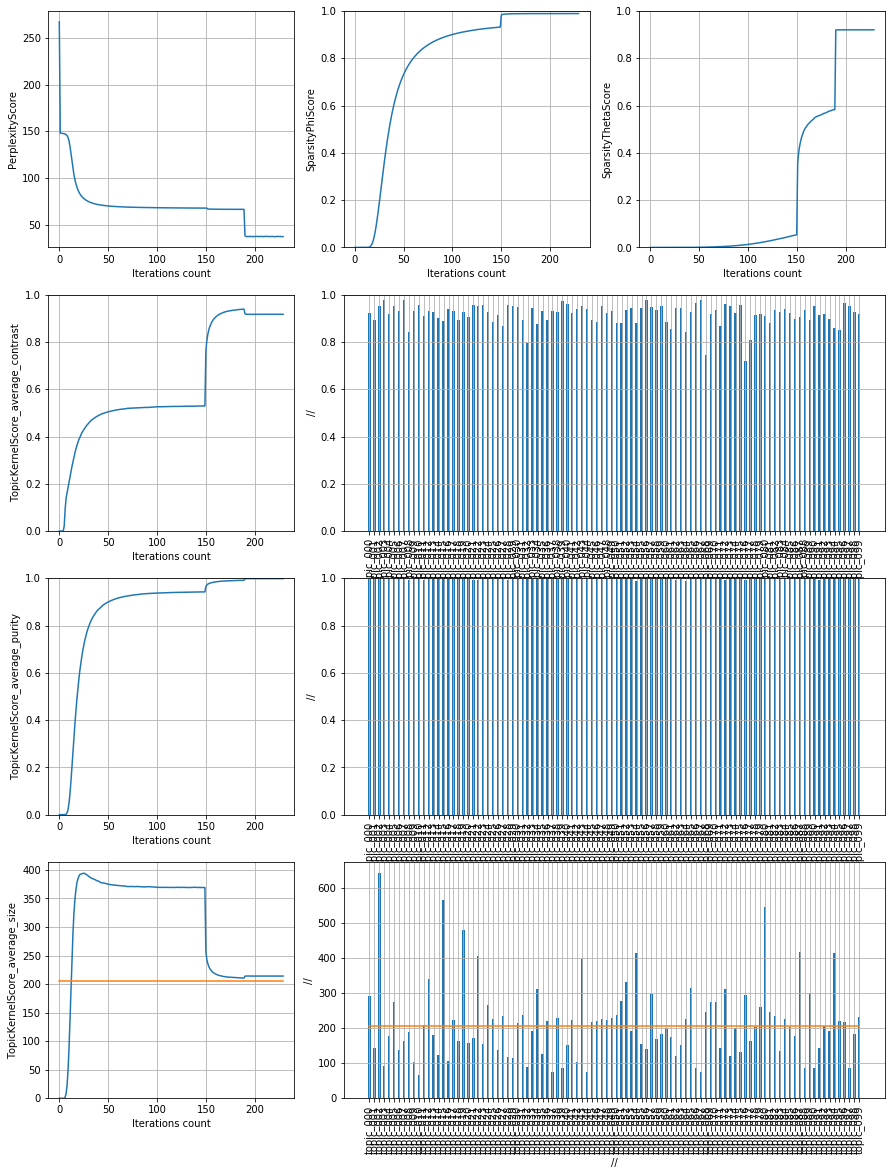

PerplexityScore: 37.05272674560547
SparsityPhiScore: 0.9895275831222534
SparsityThetaScore: 0.9208189845085144

TopicKernelScore_average_contrast: 0.9171846508979797
TopicKernelScore_average_purity: 0.9988203644752502
TopicKernelScore_average_size: 214.05999755859375

TopTokensScore:
topic_000: ученый исследование использовать коллега примерно обнаруживать университет опубликовывать анализ лаборатория 
topic_001: пост палата отставка полномочие возглавлять собрание парламентский обязанность президентский спикер 
topic_002: рука пора жить стоять маленький правда глаз совсем оставлять впрочем 
topic_003: франция французский поддерживать участвовать игорь париж инициатива нынешний тариф объединение 
topic_004: турция израиль западный израильский восточный турецкий палестинский восток сектор вулкан 
topic_005: владивосток вертолет море морской корабль флот приморье дальний восток поиск 
topic_006: граница ассоциация торговля партнер таможенный посол делегация перспектива пространство свобо

topic_079: этап сезон испания серия гонка четвертый завершаться пятый кубок бразилия 
topic_080: роль режиссер актер кино картина снимать актриса кадр звезда герой 
topic_081: кандидат избирательный голосование голос избиратель кампания проголосовать молдавия президентский опрос 
topic_082: понимать видеть всегда собственный разный интервью далеко часто уверенный пример 
topic_083: округ реализация обеспечение дополнительный обеспечивать финансирование выделять совещание субъект инфраструктура 
topic_084: жилье квартира квадратный жилой помещение ремонт земельный жилищный этаж уточнять 
topic_085: законодательство чиновник административный штраф судебный имущество арбитражный постановление рассмотрение регистрация 
topic_086: греция кризис расход внешний увеличение расти сокращение риск минфин дефицит 
topic_087: искусство современный открываться художник собирать фотография организатор коллекция посетитель экспозиция 
topic_088: приходиться лишь образ мало теперь поскольку большинство

In [9]:
# Модель 0_2
# Запуск регуляризатора SparseTheta к уже включенному SparsePhi

# Загрузка модели
model_artm = model_artm_0_1.clone()

# Регуляризатор SparsePhi
# Создание регуляризатора если он уже не создан
if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']

# Регуляризатор SparseTheta
# Создание регуляризатора если он уже не создан
if params['SparseTheta']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name=params['SparseTheta']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparseTheta']['name']].tau = params['SparseTheta']['tau']

# Обучение модели
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])

# Вывод метрик модели
model_print_results(model_artm)

# Сохранение модели
model_artm.save("news_model_0_2")
model_artm_0_2 = model_artm.clone()

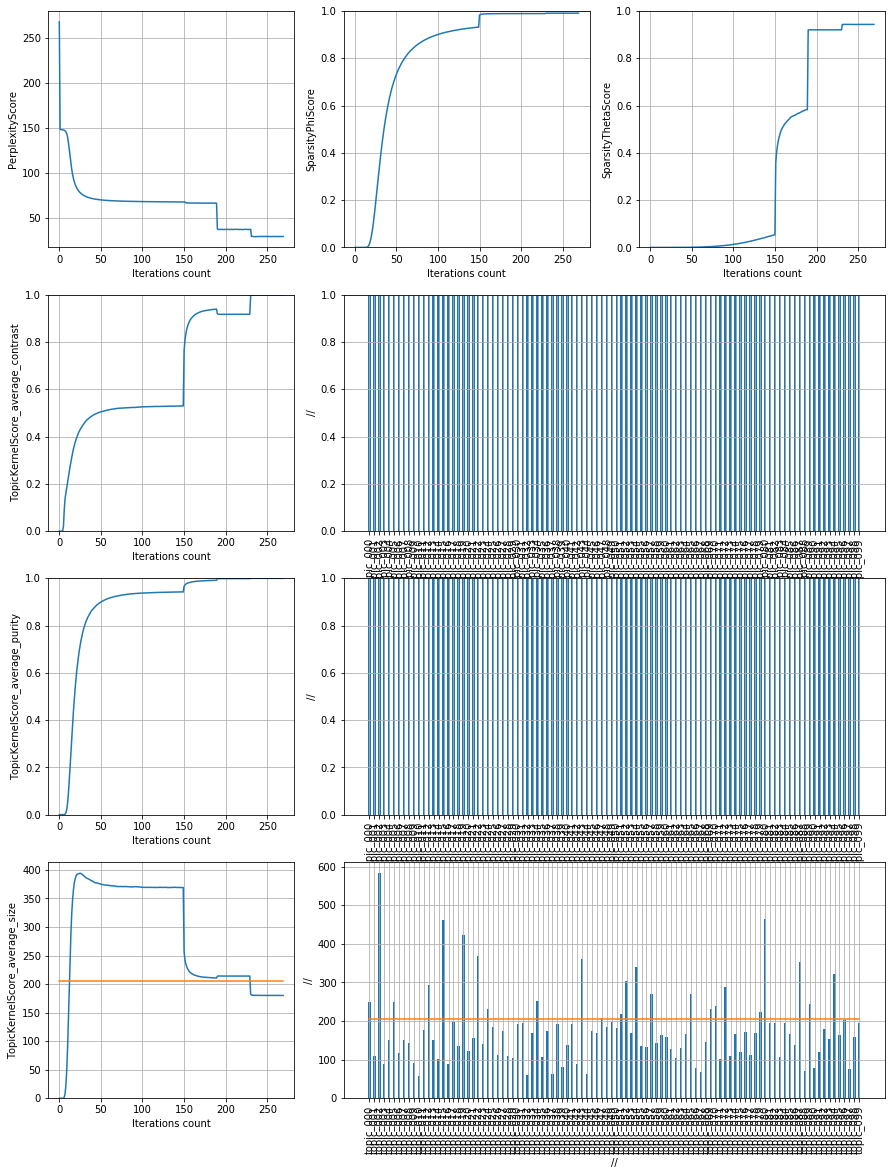

PerplexityScore: 29.19808006286621
SparsityPhiScore: 0.9912002682685852
SparsityThetaScore: 0.9436391592025757

TopicKernelScore_average_contrast: 0.9996683597564697
TopicKernelScore_average_purity: 0.9999994039535522
TopicKernelScore_average_size: 180.1199951171875

TopTokensScore:
topic_000: ученый исследование коллега примерно лаборатория эксперимент изучение анализ изучать метод 
topic_001: пост возглавлять кандидатура спикер фракция обязанность досрочный действующий парламентарий матвиенко 
topic_002: рука маленький совсем глаз впрочем узнавать слишком подходить снова совпадать 
topic_003: франция французский поддерживать участвовать париж инициатива игорь нынешний тариф объединение 
topic_004: израиль турция израильский западный турецкий восточный палестинский вулкан ближний еврейский 
topic_005: владивосток вертолет море морской флот приморье приморский хабаровск поиск амурский 
topic_006: граница ассоциация торговля партнер таможенный делегация посол партнерство свободный литва

topic_078: услуга электронный информационный оператор карта мобильный канал форма компьютер обслуживание 
topic_079: этап испания гонка серия четвертый пятый завершаться бразилия испанский стартовать 
topic_080: роль актер кино снимать актриса кадр продюсер кинотеатр съемка студия 
topic_081: кандидат избирательный голосование голос избиратель кампания проголосовать молдавия опрос прохоров 
topic_082: понимать видеть всегда собственный интервью далеко пример уверенный взгляд действительно 
topic_083: реализация округ обеспечение дополнительный обеспечивать финансирование выделять инфраструктура предоставление поручать 
topic_084: жилье квартира квадратный жилой помещение земельный ремонт жилищный снос капитальный 
topic_085: законодательство штраф чиновник административный имущество постановление регистрация кодекс коррупция юридический 
topic_086: греция расход увеличение внешний сокращение дефицит минфин расти инфляция сокращать 
topic_087: искусство художник фотография коллекция соб

In [10]:
# Модель 0_3
# Запуск регуляризатора DecorrelatorPhi к уже включенным SparsePhi, SparseTheta

# Загрузка модели
model_artm = model_artm_0_2.clone()

# Регуляризатор SparsePhi
# Создание регуляризатора если он уже не создан
if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']

# Регуляризатор SparseTheta
# Создание регуляризатора если он уже не создан
if params['SparseTheta']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name=params['SparseTheta']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparseTheta']['name']].tau = params['SparseTheta']['tau']

# Регуляризатор DecorrelatorPhi
# Создание регуляризатора если он уже не создан
if params['DecorrelatorPhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name=params['DecorrelatorPhi']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['DecorrelatorPhi']['name']].tau = params['DecorrelatorPhi']['tau']

# Обучение модели
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])

# Вывод метрик модели
model_print_results(model_artm)

# Сохранение модели
model_artm.save("news_model_0_3")
model_artm_0_3 = model_artm.clone()

In [11]:
phi = model_artm.phi_
phi

,topic_000,topic_001,topic_002,topic_003,topic_004,topic_005,topic_006,topic_007,topic_008,topic_009,...,topic_090,topic_091,topic_092,topic_093,topic_094,topic_095,topic_096,topic_097,topic_098,topic_099
карастелев,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0
гиббс,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0
холбрук,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0
тенге,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0
некляев,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0
змий,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0
летальность,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0
кровоточивость,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0
геморрагия,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0
касабланка,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0


In [12]:
theta = model_artm.get_theta()
theta

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,21990,21991,21992,21993,21994,21995,21996,21997,21998,21999
topic_000,3.147952e-03,2.306703e-01,7.148868e-11,1.775315e-04,0.000000e+00,3.490779e-04,1.351302e-04,1.916499e-03,2.564459e-02,2.377596e-03,...,2.733421e-03,1.708656e-02,1.519245e-16,1.117106e-14,3.727683e-03,3.124236e-03,0.000000e+00,4.906566e-04,1.447438e-02,3.343193e-03
topic_001,1.263334e-01,0.000000e+00,0.000000e+00,1.384334e-09,0.000000e+00,4.145928e-06,6.238431e-02,8.040158e-03,1.050261e-03,7.384121e-04,...,4.118685e-09,1.512938e-02,1.620085e-02,1.985698e-06,5.637787e-04,2.168709e-11,1.704671e-03,8.807958e-02,3.937567e-04,7.800522e-14
topic_002,7.599299e-04,5.629903e-04,5.941064e-10,6.515134e-06,9.057603e-11,7.045495e-03,1.255114e-02,6.549219e-04,3.239626e-02,6.542723e-04,...,2.931430e-04,2.249648e-02,3.482131e-07,5.168315e-05,5.203148e-04,1.609501e-05,7.021109e-05,0.000000e+00,4.591519e-03,1.269382e-02
topic_003,6.240449e-02,3.396069e-09,0.000000e+00,0.000000e+00,0.000000e+00,4.000687e-14,4.061801e-11,7.877341e-03,1.013514e-02,3.883485e-02,...,1.647511e-02,9.990266e-06,9.158831e-05,1.239987e-06,1.235489e-02,3.200777e-07,1.684510e-06,3.256944e-02,1.148106e-08,2.476215e-12
topic_004,6.709523e-04,2.236788e-03,8.109292e-13,2.452607e-03,1.751782e-01,7.450458e-03,2.288823e-02,1.366620e-03,2.570139e-03,2.993263e-03,...,1.778436e-02,4.339366e-04,3.266758e-02,2.860049e-03,9.240089e-05,1.431077e-03,5.703032e-08,4.864526e-03,3.188087e-04,3.611331e-03
topic_005,2.334234e-07,5.393201e-07,4.656079e-13,1.162281e-01,1.070756e-01,0.000000e+00,1.289738e-10,8.460367e-03,4.839101e-09,1.730992e-04,...,1.706257e-04,1.468586e-04,3.076648e-02,2.205328e-04,6.474754e-04,7.528595e-08,2.700322e-05,9.078609e-04,6.413248e-06,1.401042e-04
topic_006,8.911078e-07,2.794186e-03,0.000000e+00,0.000000e+00,1.593479e-05,2.079780e-02,8.856314e-04,1.010585e-02,2.023482e-03,2.163964e-03,...,1.443513e-02,6.613928e-03,2.164298e-04,1.596253e-09,6.360701e-02,1.573254e-02,4.648049e-10,2.520038e-04,6.161098e-07,2.801455e-02
topic_007,2.075000e-02,0.000000e+00,1.301560e-01,5.883391e-11,1.421485e-02,4.530685e-09,2.814174e-08,4.288562e-02,1.782002e-02,6.239270e-09,...,2.289090e-04,2.302847e-04,1.453906e-02,2.940645e-02,3.197054e-02,0.000000e+00,1.184990e-11,0.000000e+00,1.697739e-03,2.790414e-11
topic_008,8.185771e-03,5.267718e-11,1.143299e-03,2.049807e-02,0.000000e+00,2.752986e-03,1.538541e-02,1.004835e-02,5.301810e-02,1.260828e-04,...,2.330664e-03,5.445811e-04,5.257931e-02,1.132178e-03,1.472894e-15,2.223985e-07,1.428214e-14,5.426069e-04,1.722874e-03,1.157607e-06
topic_009,6.468340e-12,0.000000e+00,5.107107e-02,3.813930e-02,2.344190e-02,1.382728e-02,1.661184e-10,5.816721e-02,7.997128e-11,7.887342e-04,...,3.627967e-15,7.565392e-03,2.167980e-14,6.253594e-09,2.118660e-14,1.727342e-02,3.609835e-04,0.000000e+00,1.131709e-02,2.885300e-02
